**Commentaire**
This example demonstrates how to do structured data classification using TabTransformer, a deep tabular data modeling architecture for supervised and semi-supervised learning. The TabTransformer is built upon self-attention based Transformers. The Transformer layers transform the embeddings of categorical features into robust contextual embeddings to achieve higher predictive accuracy.

In [1]:
pip install -U tensorflow-addons


     |████████████████████████████████| 1.1 MB 8.1 MB/s 


In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)

In [7]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]

In [8]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

In [9]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [10]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history


In [11]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [12]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [13]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

Total model weights: 109629


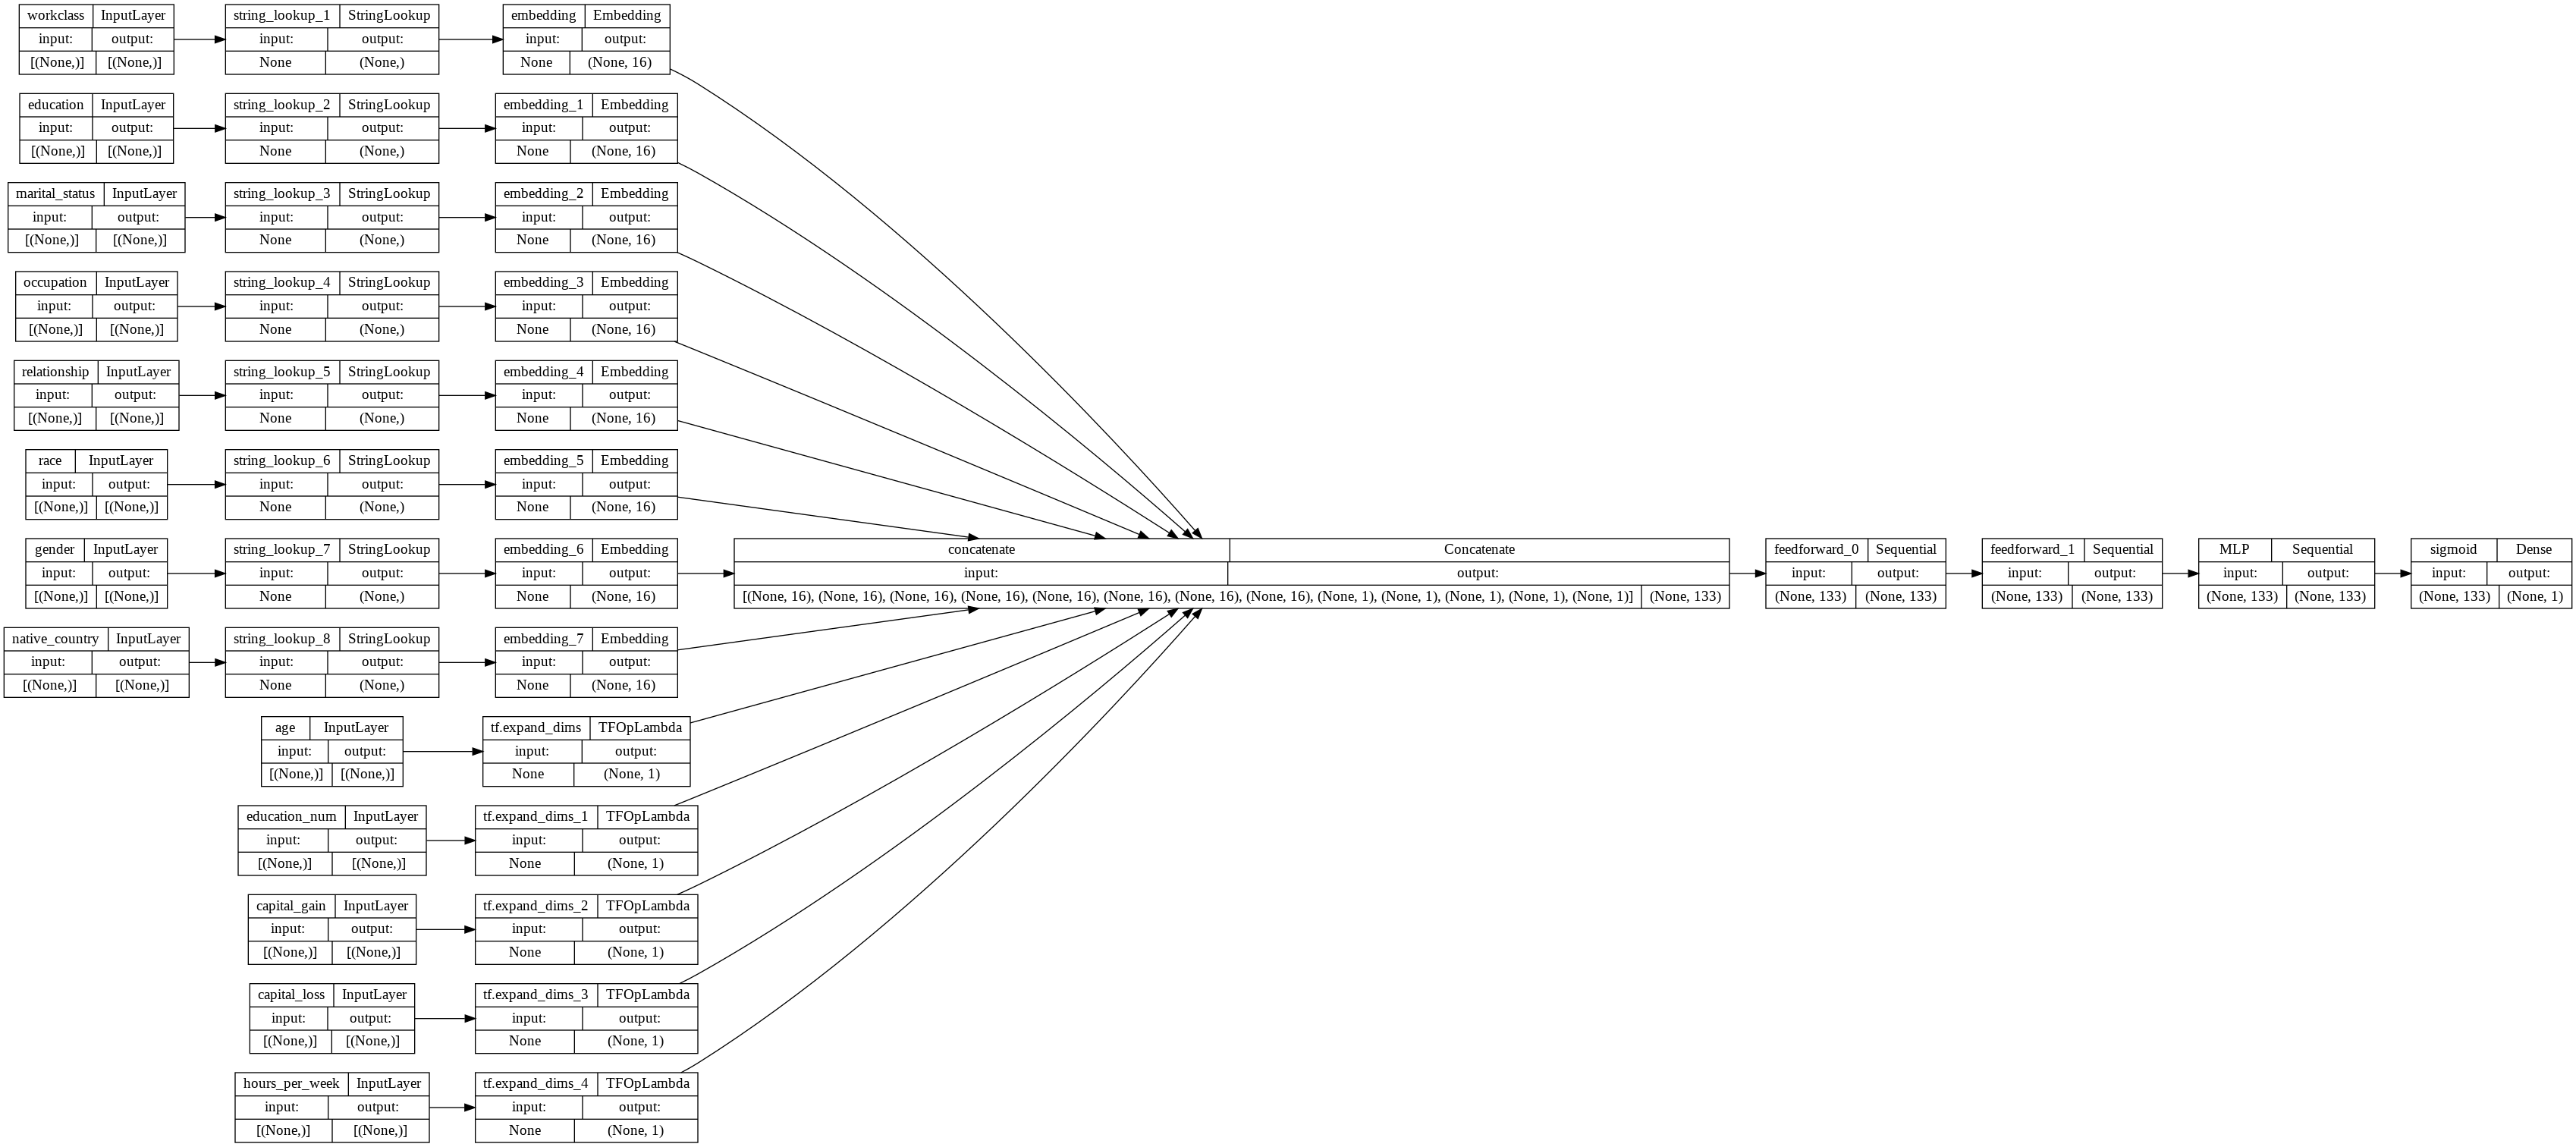

In [14]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


In [15]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    121/Unknown - 8s 36ms/step - loss: 109646.7188 - accuracy: 0.7468

123/123 [==============================] - 9s 47ms/step - loss: 109597.5859 - accuracy: 0.7472 - val_loss: 95281.8516 - val_accuracy: 0.7812
Epoch 2/15
123/123 [==============================] - ETA: 0s - loss: 93268.0703 - accuracy: 0.7704

123/123 [==============================] - 3s 22ms/step - loss: 93268.0703 - accuracy: 0.7704 - val_loss: 72944.6250 - val_accuracy: 0.7995
Epoch 3/15
123/123 [==============================] - ETA: 0s - loss: 75741.9453 - accuracy: 0.7941

123/123 [==============================] - 3s 24ms/step - loss: 75741.9453 - accuracy: 0.7941 - val_loss: 70177.8359 - val_accuracy: 0.8162
Epoch 4/15
121/123 [============================>.] - ETA: 0s - loss: 71935.1562 - accuracy: 0.8043

123/123 [==============================] - 3s 25ms/step - loss: 71912.8828 - accuracy: 0.8044 - val_loss: 68183.9141 - val_accuracy: 0.7980
Epoch 5/15
122/123 [============================>.] - ETA: 0s - loss: 70627.6328 - accuracy: 0.8055

123/123 [==============================] - 3s 23ms/step - loss: 70554.2812 - accuracy: 0.8057 - val_loss: 68265.1953 - val_accuracy: 0.8067
Epoch 6/15
121/123 [============================>.] - ETA: 0s - loss: 69498.2344 - accuracy: 0.8077

123/123 [==============================] - 3s 22ms/step - loss: 69473.7891 - accuracy: 0.8080 - val_loss: 67545.6719 - val_accuracy: 0.8074
Epoch 7/15
121/123 [============================>.] - ETA: 0s - loss: 68473.9688 - accuracy: 0.8120

123/123 [==============================] - 3s 24ms/step - loss: 68504.8828 - accuracy: 0.8122 - val_loss: 68547.1250 - val_accuracy: 0.8036
Epoch 8/15
121/123 [============================>.] - ETA: 0s - loss: 68022.8906 - accuracy: 0.8144

123/123 [==============================] - 3s 20ms/step - loss: 67985.5625 - accuracy: 0.8145 - val_loss: 68083.2734 - val_accuracy: 0.8068
Epoch 9/15
122/123 [============================>.] - ETA: 0s - loss: 68033.9297 - accuracy: 0.8124

123/123 [==============================] - 3s 23ms/step - loss: 68014.0469 - accuracy: 0.8124 - val_loss: 65917.3984 - val_accuracy: 0.8138
Epoch 10/15
123/123 [==============================] - ETA: 0s - loss: 67391.3359 - accuracy: 0.8173

123/123 [==============================] - 3s 22ms/step - loss: 67391.3359 - accuracy: 0.8173 - val_loss: 66867.3203 - val_accuracy: 0.8158
Epoch 11/15
122/123 [============================>.] - ETA: 0s - loss: 67337.5938 - accuracy: 0.8149

123/123 [==============================] - 3s 25ms/step - loss: 67301.9609 - accuracy: 0.8151 - val_loss: 66633.3672 - val_accuracy: 0.8155
Epoch 12/15
123/123 [==============================] - ETA: 0s - loss: 67023.5312 - accuracy: 0.8174

123/123 [==============================] - 3s 25ms/step - loss: 67023.5312 - accuracy: 0.8174 - val_loss: 67057.6797 - val_accuracy: 0.8076
Epoch 13/15
121/123 [============================>.] - ETA: 0s - loss: 66712.6875 - accuracy: 0.8173

123/123 [==============================] - 3s 26ms/step - loss: 66701.8828 - accuracy: 0.8174 - val_loss: 66469.8203 - val_accuracy: 0.8123
Epoch 14/15
122/123 [============================>.] - ETA: 0s - loss: 66106.7422 - accuracy: 0.8209

123/123 [==============================] - 3s 24ms/step - loss: 66064.7969 - accuracy: 0.8211 - val_loss: 64928.7930 - val_accuracy: 0.8225
Epoch 15/15
123/123 [==============================] - ETA: 0s - loss: 64555.9922 - accuracy: 0.8274

123/123 [==============================] - 3s 22ms/step - loss: 64555.9922 - accuracy: 0.8274 - val_loss: 64149.7773 - val_accuracy: 0.8345


Model training finished
Validation accuracy: 83.45%


Total model weights: 87479


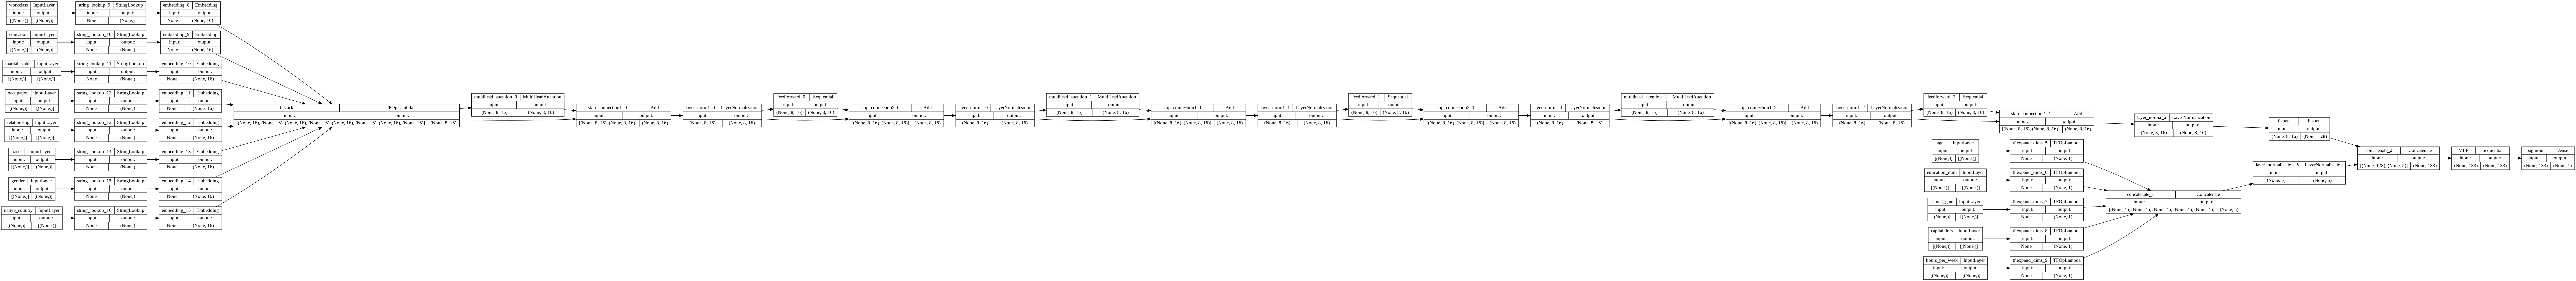

In [16]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

In [17]:
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

Start training the model...
Epoch 1/15
    123/Unknown - 22s 83ms/step - loss: 82422.0469 - accuracy: 0.7967

123/123 [==============================] - 26s 112ms/step - loss: 82422.0469 - accuracy: 0.7967 - val_loss: 64292.1680 - val_accuracy: 0.8364
Epoch 2/15
123/123 [==============================] - ETA: 0s - loss: 69609.3125 - accuracy: 0.8251

123/123 [==============================] - 9s 74ms/step - loss: 69609.3125 - accuracy: 0.8251 - val_loss: 62358.8242 - val_accuracy: 0.8449
Epoch 3/15
123/123 [==============================] - ETA: 0s - loss: 66669.6953 - accuracy: 0.8299

123/123 [==============================] - 9s 74ms/step - loss: 66669.6953 - accuracy: 0.8299 - val_loss: 62116.0586 - val_accuracy: 0.8450
Epoch 4/15
123/123 [==============================] - ETA: 0s - loss: 64839.7969 - accuracy: 0.8355

123/123 [==============================] - 9s 72ms/step - loss: 64839.7969 - accuracy: 0.8355 - val_loss: 61842.1406 - val_accuracy: 0.8441
Epoch 5/15
123/123 [==============================] - ETA: 0s - loss: 64493.6172 - accuracy: 0.8350

123/123 [==============================] - 10s 82ms/step - loss: 64493.6172 - accuracy: 0.8350 - val_loss: 61827.1211 - val_accuracy: 0.8430
Epoch 6/15
123/123 [==============================] - ETA: 0s - loss: 63418.9023 - accuracy: 0.8391

123/123 [==============================] - 9s 71ms/step - loss: 63418.9023 - accuracy: 0.8391 - val_loss: 61601.7539 - val_accuracy: 0.8431
Epoch 7/15
123/123 [==============================] - ETA: 0s - loss: 62602.7461 - accuracy: 0.8391

123/123 [==============================] - 9s 74ms/step - loss: 62602.7461 - accuracy: 0.8391 - val_loss: 61360.6367 - val_accuracy: 0.8445
Epoch 8/15
123/123 [==============================] - ETA: 0s - loss: 62333.1445 - accuracy: 0.8412

123/123 [==============================] - 9s 71ms/step - loss: 62333.1445 - accuracy: 0.8412 - val_loss: 62053.5312 - val_accuracy: 0.8405
Epoch 9/15
123/123 [==============================] - ETA: 0s - loss: 62458.5195 - accuracy: 0.8409

123/123 [==============================] - 9s 71ms/step - loss: 62458.5195 - accuracy: 0.8409 - val_loss: 61078.1875 - val_accuracy: 0.8459
Epoch 10/15
123/123 [==============================] - ETA: 0s - loss: 62042.6133 - accuracy: 0.8402

123/123 [==============================] - 10s 78ms/step - loss: 62042.6133 - accuracy: 0.8402 - val_loss: 61018.9102 - val_accuracy: 0.8465
Epoch 11/15
123/123 [==============================] - ETA: 0s - loss: 61815.5078 - accuracy: 0.8427

123/123 [==============================] - 9s 73ms/step - loss: 61815.5078 - accuracy: 0.8427 - val_loss: 61840.1250 - val_accuracy: 0.8441
Epoch 12/15
123/123 [==============================] - ETA: 0s - loss: 61927.8828 - accuracy: 0.8413

123/123 [==============================] - 9s 72ms/step - loss: 61927.8828 - accuracy: 0.8413 - val_loss: 61165.4727 - val_accuracy: 0.8453
Epoch 13/15
123/123 [==============================] - ETA: 0s - loss: 61381.8750 - accuracy: 0.8428

123/123 [==============================] - 9s 71ms/step - loss: 61381.8750 - accuracy: 0.8428 - val_loss: 61303.5078 - val_accuracy: 0.8445
Epoch 14/15
123/123 [==============================] - ETA: 0s - loss: 61446.7891 - accuracy: 0.8433

123/123 [==============================] - 9s 70ms/step - loss: 61446.7891 - accuracy: 0.8433 - val_loss: 60966.8320 - val_accuracy: 0.8457
Epoch 15/15
123/123 [==============================] - ETA: 0s - loss: 61463.0508 - accuracy: 0.8428

123/123 [==============================] - 9s 69ms/step - loss: 61463.0508 - accuracy: 0.8428 - val_loss: 61053.9805 - val_accuracy: 0.8458


Model training finished
Validation accuracy: 84.58%


**Conclusion**
TabTransformer significantly outperforms MLP and recent deep networks for tabular data while matching the performance of tree-based ensemble models. TabTransformer can be learned in end-to-end supervised training using labeled examples. For a scenario where there are a few labeled examples and a large number of unlabeled examples, a pre-training procedure can be employed to train the Transformer layers using unlabeled data. This is followed by fine-tuning of the pre-trained Transformer layers along with the top MLP layer using the labeled data.

Example available on HuggingFace.

